# Clip Vector and Raster data

#### The clip tool in GIS is used to extract a subset of data from a larger dataset based on a specified boundary or extent. It allows you to "clip" or cut out a portion of the original dataset that falls within the boundary or extent you define.

#### In the context of vector data, the clip tool is typically used to extract features (points, lines, polygons) that intersect with a specified polygon boundary. The resulting dataset will only include the features that are within the clipping polygon.

#### In the context of raster data, the clip tool is used to extract a portion of the raster that falls within a specified boundary or extent. This can be useful when you only need to work with a specific area of interest within a larger raster dataset. The resulting clipped raster will have the same spatial resolution as the original raster, but it will only contain the pixels that fall within the clipping boundary.

#### Both the vector and raster clip tools are commonly used in GIS analysis and data processing workflows to subset data and focus on specific areas of interest.

## Clip Vector data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import rasterio
from rasterio import mask
import os
import glob

## Clip Vector using Shapefile

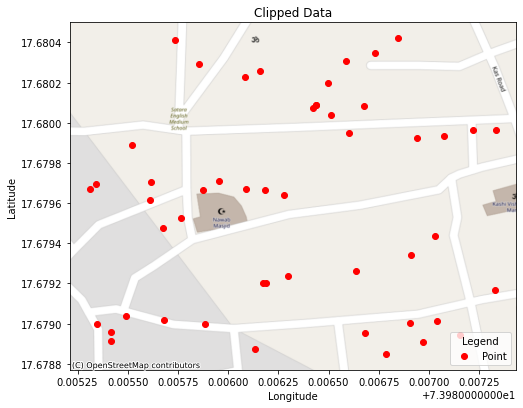

In [2]:
# Load the shapefile clip boundary
clip_boundary = gpd.read_file('E:/Python/Geospatial python/data/vector/AOI.shp')

# Load the vector dataset to be clipped
vector_data = gpd.read_file('E:/Python/Geospatial python/data/vector/Tree.shp')

# Perform the clip operation
clipped_data = gpd.clip(vector_data, clip_boundary)

# Save the clipped dataset to a new shapefile
clipped_data.to_file('E:/Python/Geospatial python/data/Output/clipped_data.shp')

# Read the shapefile
data = gpd.read_file('E:/Python/Geospatial python/data/Output/clipped_data.shp')

# define figure dimension and axes
fig, ax = plt.subplots(figsize=(8, 8))

# plot the data
clipped_data.plot(ax=ax, color='red', label='Point')

# add title, xlabel, ylabel, legend
plt.title('Clipped Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Legend', loc='lower right')

# Add basemap using contextily (using OpenStreetMap)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=clipped_data.crs)

# Show the plot
plt.show()

## Clip - Batch Processing Vector files

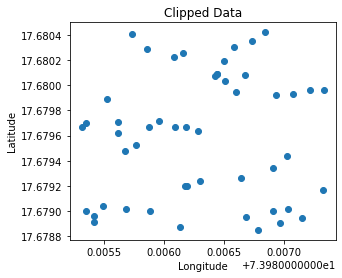

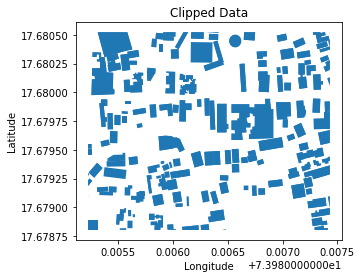

In [3]:
# Load the shapefile clip boundary
clip_boundary = gpd.read_file('E:/Python/Geospatial python/data/vector/AOI.shp')

# List of shapefiles to be clipped
shapefile_list = ['E:/Python/Geospatial python/data/vector/Tree.shp', 'E:/Python/Geospatial python/data/vector/Building.shp']

# Iterate over the shapefile list
for shapefile_path in shapefile_list:
    # Load the shapefile
    vector_data = gpd.read_file(shapefile_path)
    
    # Perform the clip operation
    clipped_data = gpd.clip(vector_data, clip_boundary)
    
    # Define the output path for the clipped shapefile
    output_path = shapefile_path.replace('.shp', '_clipped.shp')
    
    # Save the clipped shapefile
    clipped_data.to_file(output_path)
    
    # Plot the clipped data
    fig, ax = plt.subplots()
    clipped_data.plot(ax=ax)
    plt.title('Clipped Data')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

## Clip Raster

## Clip Raster using mask (shapefile)

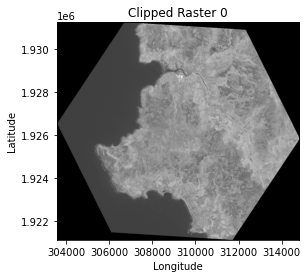

In [4]:
# Read the shapefile
shapefile = gpd.read_file('E:/Python/Geospatial python/data/AOI.shp')

# Read the raster dataset
dataset = rasterio.open('E:/Python/Geospatial python/data/B08.tif')

# Iterate over each polygon in the shapefile
for index, geometry in shapefile.geometry.iteritems():
    # Clip the raster dataset based on the polygon extent
    clipped, transform = mask.mask(dataset, shapes=[geometry], crop=True)

    # Update the metadata of the clipped dataset
    clipped_meta = dataset.meta
    clipped_meta.update({
        'transform': transform,
        'height': clipped.shape[1],
        'width': clipped.shape[2]
    })

    # Plot the clipped raster
    fig, ax = plt.subplots()
    plt.imshow(clipped[0], cmap='gray', extent=(transform[2], transform[2]+transform[0]*clipped.shape[2], transform[5]+transform[4]*clipped.shape[1], transform[5]))
    plt.title(f'Clipped Raster {index}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# wrire the output in tif file
with rasterio.open('E:/Python/Geospatial python/data/B08_clipped.tif', "w", **clipped_meta) as dest:
    dest.write(clipped)

## Clip - Batch Processing Raster files

In [5]:
# Read the shapefile
shapefile = gpd.read_file('E:/Python/Geospatial python/data/AOI.shp')

# Define the folder path containing the TIFF files
folder_path = 'E:/Python/Geospatial python/data/raster/'

# Get a list of all TIFF files in the folder
tif_files = glob.glob(os.path.join(folder_path, '*.tif'))

# Iterate over the TIFF files
for raster_file in tif_files:
    # Open the raster dataset
    with rasterio.open(raster_file) as src:
        # Clip the raster dataset based on the shapefile geometry
        clipped, transform = mask.mask(src, shapes=shapefile.geometry, crop=True)

        # Create a new raster dataset with the clipped data and updated metadata
        clipped_meta = src.meta
        clipped_meta.update({
            'height': clipped.shape[1],
            'width': clipped.shape[2],
            'transform': transform
        })

        # Get the original raster file name
        raster_filename = os.path.splitext(os.path.basename(raster_file))[0]

        # Generate a unique name for the clipped raster
        clipped_filename = f'clipped_{raster_filename}.tif'

        # Construct the output path for the clipped raster
        clipped_path = os.path.join('E:/Python/Geospatial python/data/raster/', clipped_filename)

        # Write the clipped raster to the output file
        with rasterio.open(clipped_path, 'w', **clipped_meta) as dst:
            dst.write(clipped, indexes=src.indexes)